<a href="https://colab.research.google.com/github/suyashdamle/deep_learning_projects/blob/master/pytorch_tut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import numpy as np

In [2]:
torch.cuda.get_device_name(0)

'Tesla T4'

# NOTES:
- Memory is shared between np and torch arrays, after inter-conversions - a change in one reflects in other
- **IMP:  Underscores (' _ ')  represent in-place ops**
-  The first dimension could be keprt the batch_size. Then,
    - W1 : ip_features X n_hidden_1
    - W2 : n_hidden_1 X n_hidden_2 & so on...
- AutoGrad keeps track of outputs of the **leaf nodes only** - in this case, only weights and biases: [look this up](https://towardsdatascience.com/pytorch-autograd-understanding-the-heart-of-pytorchs-magic-2686cd94ec95)
- Be careful with the leaf variables:
  - They should not be overwritten by other objects (ie, ops such as W1 = W1 - lr*grad)
  - In-place ops are NOT allowed over them
  - So, just use the '.data'  notation to replace values during update operations

# Simple Feed-Forward net from scratch using AutoGrad feature

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision import datasets, transforms

In [4]:
trainset = datasets.MNIST('data/',download = True, train= True, transform=transforms.ToTensor())                 #convert images to tensors
testset = datasets.MNIST('data/',download = True, train= False, transform=transforms.ToTensor())
loader = torch.utils.data.DataLoader(trainset,batch_size = 100, shuffle=True)
data_iter = iter(loader)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 20671408.31it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 316144.21it/s]                           
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 5082206.04it/s]                           
8192it [00:00, 128232.86it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


torch.Size([100, 1, 28, 28])


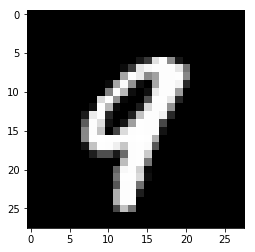

tensor(9)


In [5]:
images,labels = data_iter.next()
print(images.shape)
plt.imshow(images[0].numpy().squeeze(),cmap='gray')
plt.show()
print(labels[0])

In [0]:
# defining the weights
W1 = torch.tensor(np.random.normal(loc = 0., scale=0.01, size=(784,300)),requires_grad=True,dtype=torch.float)
B1 = torch.tensor(np.random.normal(loc = 0., scale=0.01, size=(1,300)),requires_grad = True,dtype=torch.float)

W2 = torch.tensor(np.random.normal(loc = 0., scale=0.01, size=(300,100)), requires_grad=True,dtype=torch.float)
B2 = torch.tensor(np.random.normal(loc = 0., scale=0.01, size=(1,100)),requires_grad = True,dtype=torch.float)

W3 = torch.tensor(np.random.normal(loc = 0., scale=0.01, size=(100,10)), requires_grad=True,dtype=torch.float)
B3 = torch.tensor(np.random.normal(loc = 0., scale=0.01, size=(1,10)),requires_grad = True,dtype=torch.float)


lr = 0.01

In [0]:
loss_fn = torch.nn.CrossEntropyLoss()

def forward_pass(X):
  X = X.view(-1,784)
  h1 = torch.tanh(torch.mm(X,W1)+B1)     # batch_size X n_hidden_1
  h2 = torch.tanh(torch.mm(h1,W2)+B2)    # batch_size X n_hidden_2
  o = torch.tanh(torch.mm(h2,W3)+B3)     # batch_size X n_output
  
  # softmax
  d_r = torch.sum(torch.exp(o),dim=1)    # the denominator: size(50,)
  d_r = d_r.view(-1,1)                   # one sum - per row
  logits = torch.exp(o)/d_r 
  return logits

def backward_pass(logits,y):
  global W1, W2, B1, B2, W3, B3
  
  # get cross-entropy loss
  loss = loss_fn(logits, y)
  # calculate the gradients
  loss.backward()
  
  # update the weights and biases accordingly
  # NOTE: directly using mathematical operations would overwrite variables - they would not be leaves anymore
  # NOTE: leaf variables could not be directly operated upon
  # Using the average of the gradient over the batch

  W1.data = W1.sub(lr*W1.grad.data).data
  B1.data = B1.sub(lr*B1.grad.data).data
  W2.data = W2.sub(lr*W2.grad.data).data
  B2.data = B2.sub(lr*B2.grad.data).data
  W3.data = W3.sub(lr*W3.grad.data).data
  B3.data = B3.sub(lr*B3.grad.data).data
  return  loss

In [41]:
display_step = 5
for ep in range(20):
  data_iter = iter(loader)                 # resetting the iterator
  for images,labels in data_iter:          # a mini-batch
    logits= forward_pass(images)           # getting the probs
    loss = backward_pass(logits, labels)   # updating weights for this mini-batch
  if ep%display_step == 0:
    print("Epoch # %d: Loss: %f"%(ep, loss.data))
    
# print a sample of labels and predictions to get a feel
print(logits.argmax(dim=1))
print(labels)

Epoch # 0: Loss: 2.153310
Epoch # 5: Loss: 2.049981
Epoch # 10: Loss: 2.036253
Epoch # 15: Loss: 2.034521
tensor([9, 5, 9, 8, 9, 9, 3, 9, 0, 0, 4, 5, 1, 1, 3, 5, 0, 3, 9, 9, 2, 1, 2, 8,
        5, 9, 5, 2, 2, 1, 1, 5, 9, 5, 2, 1, 9, 6, 9, 5, 1, 9, 9, 5, 2, 9, 6, 3,
        6, 9, 3, 8, 9, 9, 9, 1, 4, 3, 9, 4, 9, 2, 3, 4, 1, 5, 4, 2, 9, 2, 5, 3,
        5, 6, 9, 1, 1, 9, 4, 9, 7, 6, 8, 1, 3, 6, 5, 5, 2, 5, 1, 2, 3, 4, 9, 6,
        8, 2, 9, 4])
tensor([9, 5, 4, 5, 7, 4, 3, 8, 0, 9, 4, 0, 1, 1, 3, 5, 0, 3, 9, 4, 2, 2, 8, 5,
        0, 9, 0, 2, 3, 1, 1, 0, 8, 9, 2, 1, 9, 6, 3, 0, 1, 7, 3, 5, 2, 8, 6, 3,
        6, 7, 3, 0, 4, 1, 9, 1, 4, 3, 7, 4, 2, 2, 3, 4, 1, 0, 5, 3, 7, 2, 7, 3,
        5, 6, 7, 1, 1, 7, 4, 9, 7, 6, 5, 1, 0, 6, 4, 1, 2, 0, 1, 1, 3, 4, 8, 6,
        8, 3, 4, 4])
